In [ ]:
import os
import torch
import torch
from torchvision import transforms
from transformers import BertTokenizer
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

ROOT = f"{os.getcwd()}/pmc_dataset/process"
MODEL_DIR = f"{ROOT}/log/checkpoint.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.chdir(ROOT)

In [ ]:
DATA_ROOT = '/datasets/PMC-15M'
SAMPLE_DATA = f'{DATA_ROOT}/0.jsonl'

# Load sample jsonl file
with open(SAMPLE_DATA, 'r') as f:
    dataset = [eval(line) for line in f]

sample = dataset[2323]
print(f"Dataset size: {len(dataset)}"); sample

In [ ]:
checkpoint = torch.load(MODEL_DIR, map_location=device)
checkpoint.keys()

In [ ]:
model_state_dict = checkpoint['model_state_dict']
print(model_state_dict.keys())

In [47]:
from model_det_align import FigCap_Former

model = FigCap_Former(
    num_query=32,
    num_encoder_layers=4,
    num_decoder_layers=4,
    num_text_decoder_layers=4,
    bert_path='bert-base-uncased',
    alignment_network=True,
    resnet_pretrained=False,
    resnet=34,
    feature_dim=256,  # Assuming this is the same as hidden_dim in the original code
    atten_head_num=8,  # Using the default from the original code
    text_atten_head_num=8,  # Using the default from the original code
    mlp_ratio=4,  # Using the default from the original code
    dropout=0.0,  # Using the default from the original code
    activation='relu',  # Using the default from the original code
    text_mlp_ratio=4,  # Using the default from the original code
    text_dropout=0.0,  # Using the default from the original code
    text_activation='relu'  # Using the default from the original code
)
model.load_state_dict(model_state_dict)
# print(model.state_dict().keys())

# # model = nn.DataParallel(model)
# model.to(device)
# img = torch.rand(4, 3, 128, 128).to(device)
# text = torch.randint(1, 30000, (4, 100)).to(device)
# a, b, c = model(img, text)
# print(a.shape)
# print(a[0,0,0])
# print(b.shape)
# print(c.shape)
# print(c[0,0,0])

<All keys matched successfully>

In [49]:
# 1. Prepare input data
# Image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_path = "/datasets/PMC-15M/figures/PMC517716_F1.jpg/1471-2407-4-58-1.jpg"
image = Image.open(image_path)
image_tensor = image_transform(image).unsqueeze(0)  # Add batch dimension

# Text preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
caption = sample['caption']  # Assuming 'sample' is defined and contains the caption
text_tokens = tokenizer(caption, return_tensors="pt", padding=True, truncation=True, max_length=512)

# 2. Set up model for inference
model.eval()
model.to(device)
torch.set_grad_enabled(False)

# 3. Run inference
image_tensor = image_tensor.to(device)
text_tokens = {k: v.to(device) for k, v in text_tokens.items()}

output_det_class, output_box, similarity = model(image_tensor, text_tokens['input_ids'])

# 4. Process outputs
detection_threshold = 0.5
positive_detections = output_det_class.squeeze() > detection_threshold
detected_boxes = output_box.squeeze()[positive_detections]
detected_similarities = similarity.squeeze()[positive_detections]

# 5. Print results
print("Number of detected objects:", positive_detections.sum().item())
print("Detected bounding boxes:")
print(detected_boxes)
print("\nDetection scores:")
print(output_det_class.squeeze()[positive_detections])
print("\nSimilarity scores shape:", detected_similarities.shape)

Number of detected objects: 4
Detected bounding boxes:
tensor([[0.7457, 0.7347, 0.4850, 0.4815],
        [0.7468, 0.2489, 0.4684, 0.4703],
        [0.2493, 0.7392, 0.4782, 0.4746],
        [0.2549, 0.2477, 0.4877, 0.4832]], device='cuda:0')

Detection scores:
tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')

Similarity scores shape: torch.Size([4, 157])


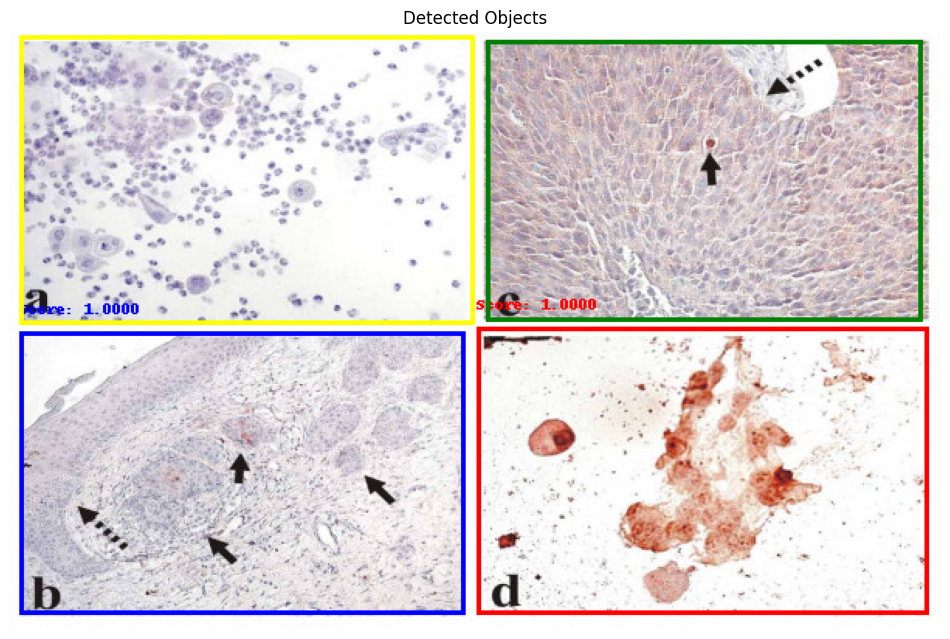

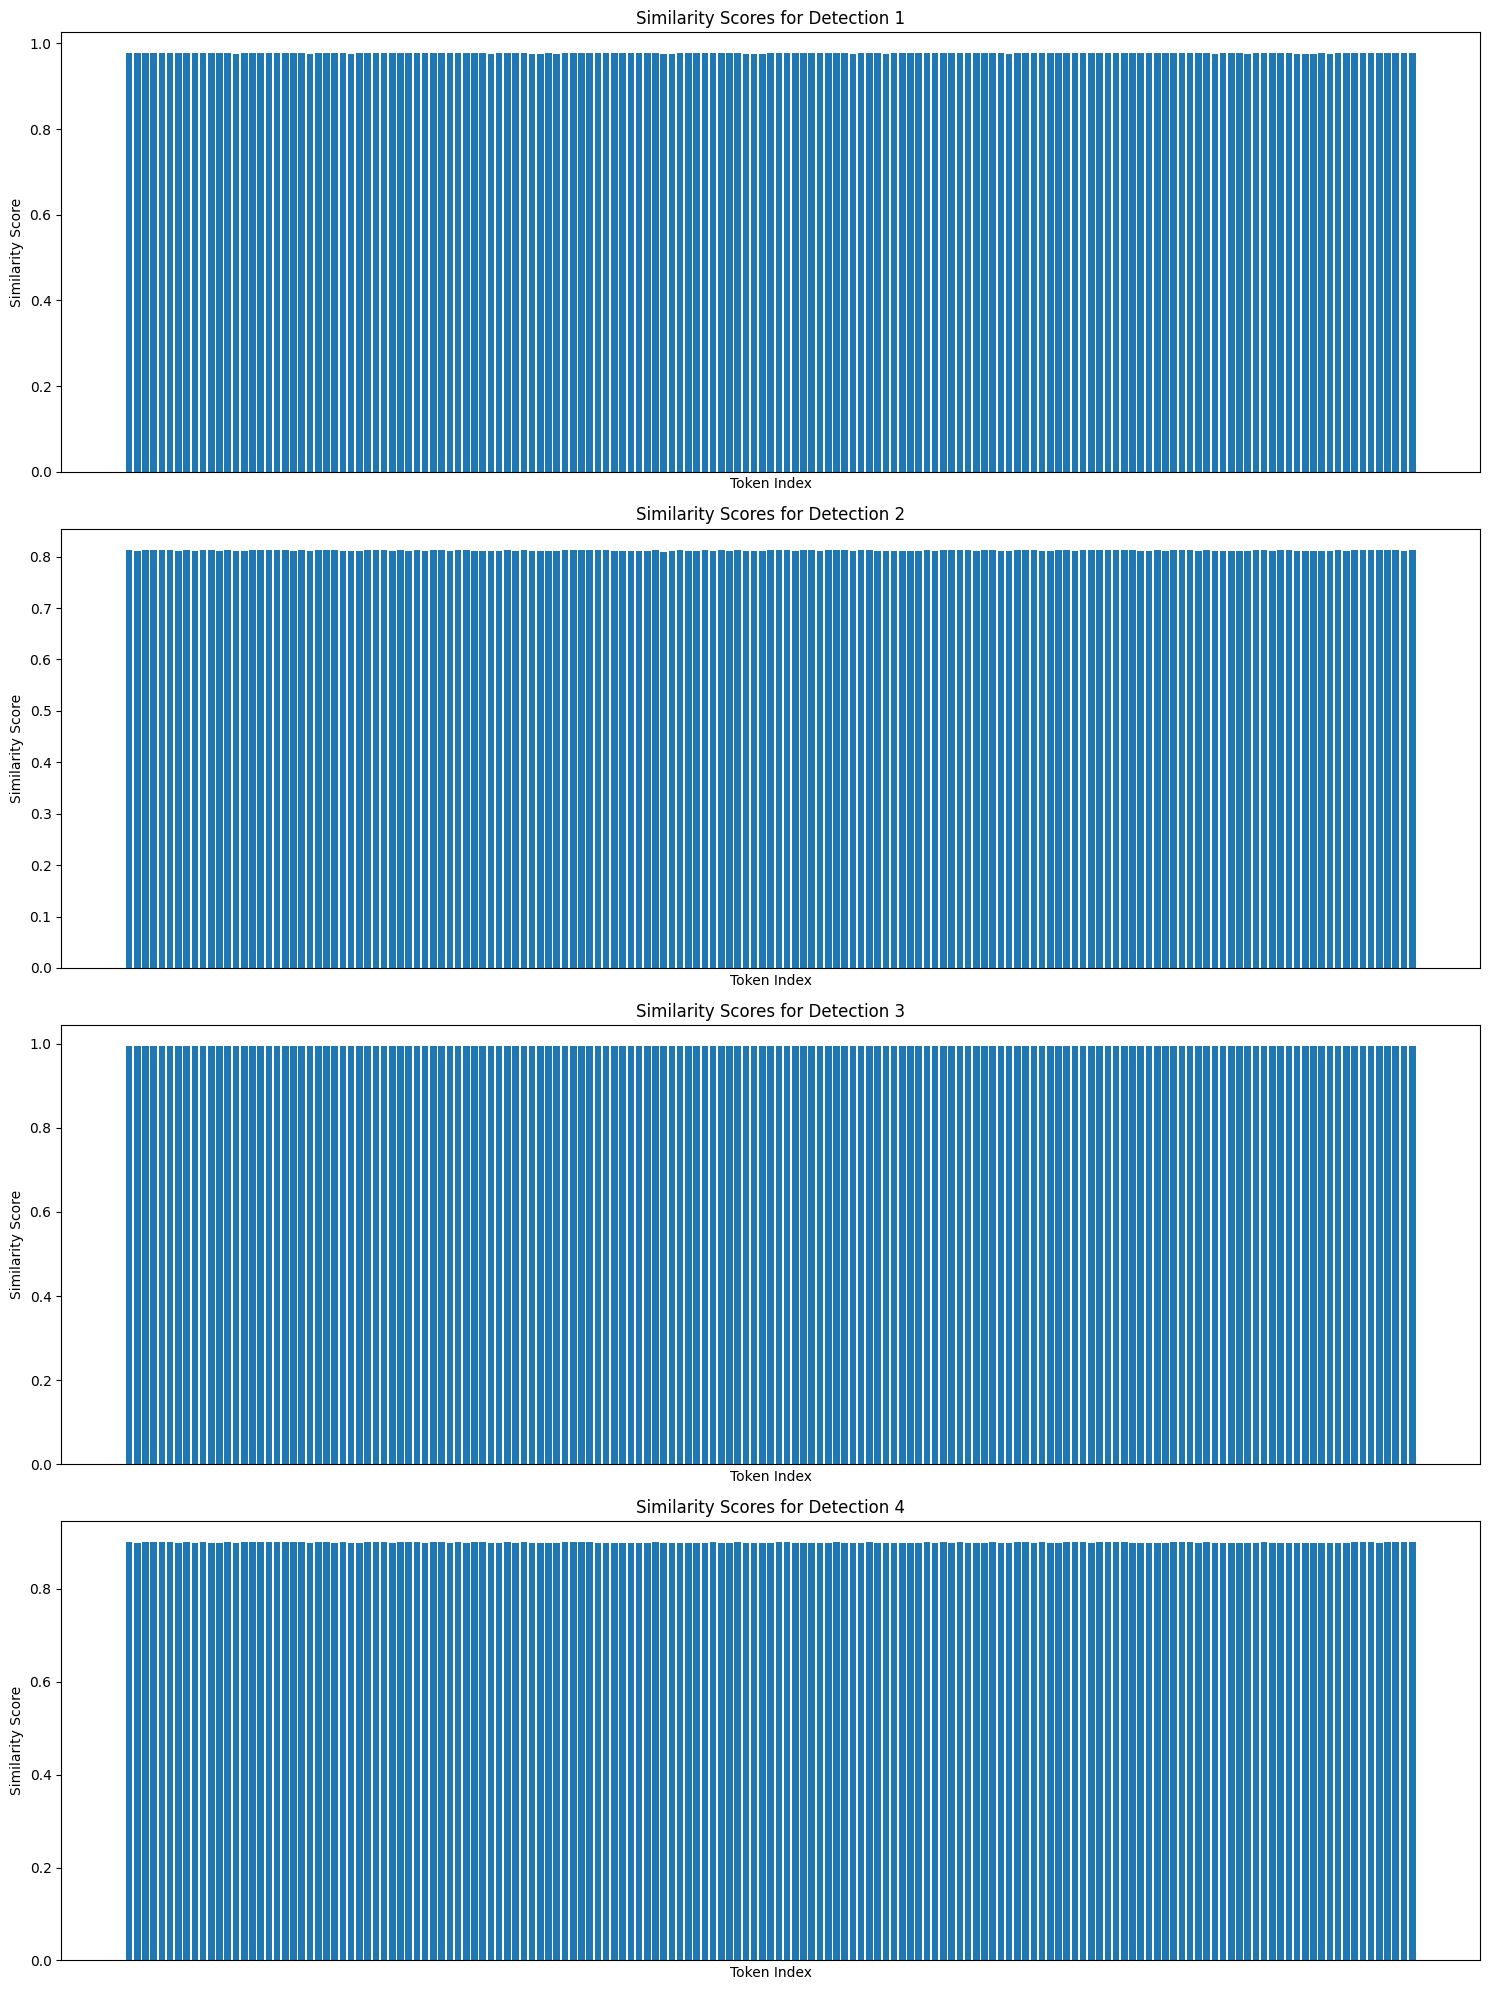


Top 5 similar tokens for Detection 1:
a: 0.9769
.: 0.9769
of: 0.9768
##ing: 0.9768
##ing: 0.9768

Top 5 similar tokens for Detection 2:
the: 0.8139
##ing: 0.8138
##ing: 0.8138
): 0.8137
cell: 0.8136

Top 5 similar tokens for Detection 3:
a: 0.9955
.: 0.9955
##ing: 0.9955
antibodies: 0.9954
): 0.9954

Top 5 similar tokens for Detection 4:
##ing: 0.9008
.: 0.9007
##ing: 0.9005
the: 0.9005
the: 0.9005

Full Caption:
[CLS] different types of cervical cell staining with the p16ink4a - specific antibodies. a. normal epithelium ( smear ) : negative staining. b. cin i ( indicated with a dotted arrow ) and cancer in situ ( solid arrows ) : a very poor cytoplasmic staining in separate cin i cells and sporadic staining in cancer in situ. c. invasive squamous cell carcinoma. diffuse cytoplasmic staining with the sole cell expressing p16ink4a in the nucleus ( solid arrow ). the boundary with adjoining normal tissue is marked with a dotted arrow. d. ht3 cells ( smear ) with both nuclear and cytopla

In [50]:
# Visualization part starts here
# Load the original image for drawing
original_image = Image.open(image_path)

# Create a drawing object
draw = ImageDraw.Draw(original_image)

# Get the image dimensions
img_width, img_height = original_image.size

# Define colors for bounding boxes
colors = ['red', 'green', 'blue', 'yellow']

# Draw bounding boxes
for i, box in enumerate(detected_boxes):
    # Convert normalized coordinates to pixel coordinates
    cx, cy, w, h = box.cpu().numpy()
    x1 = int((cx - w/2) * img_width)
    y1 = int((cy - h/2) * img_height)
    x2 = int((cx + w/2) * img_width)
    y2 = int((cy + h/2) * img_height)
    
    # Draw rectangle
    draw.rectangle([x1, y1, x2, y2], outline=colors[i % len(colors)], width=3)
    
    # Add detection score
    score = output_det_class.squeeze()[positive_detections][i].item()
    draw.text((x1, y1-20), f"Score: {score:.4f}", fill=colors[i % len(colors)])

# Display the image with matplotlib
plt.figure(figsize=(12, 12))
plt.imshow(original_image)
plt.axis('off')
plt.title("Detected Objects")
plt.show()

# Decode tokens
decoded_tokens = tokenizer.convert_ids_to_tokens(text_tokens['input_ids'][0])

# Visualize similarity scores for each detection
plt.figure(figsize=(15, 5 * detected_similarities.shape[0]))
for i in range(detected_similarities.shape[0]):
    plt.subplot(detected_similarities.shape[0], 1, i+1)
    plt.bar(range(len(decoded_tokens)), detected_similarities[i].cpu().numpy())
    plt.title(f"Similarity Scores for Detection {i+1}")
    plt.xlabel("Token Index")
    plt.ylabel("Similarity Score")
    plt.xticks([])  # Remove x-axis labels for clarity
plt.tight_layout()
plt.show()

# Print top 5 most similar tokens for each detection
for i in range(detected_similarities.shape[0]):
    similarities = detected_similarities[i].cpu().numpy()
    top5_indices = similarities.argsort()[-5:][::-1]
    print(f"\nTop 5 similar tokens for Detection {i+1}:")
    for idx in top5_indices:
        print(f"{decoded_tokens[idx]}: {similarities[idx]:.4f}")

# Print the full caption
print("\nFull Caption:")
print(tokenizer.decode(text_tokens['input_ids'][0]))